In [5]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [6]:
#Loading the dataset
data = pd.read_csv("/content/marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [7]:
#Information on features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [8]:
#To remove the NA values
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 2216


In [9]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], format= '%d-%m-%Y')
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in therecords: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


In [10]:
#Created a feature "Customer_For"
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In [11]:
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


In [12]:
#Feature Engineering
#Age of customer today
data["Age"] = 2021-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

<ipython-input-12-7ccaa6536fcb>:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]


In [ ]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,3.054423e+16,52.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,1.749036e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,25.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,1.555200e+16,44.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,3.071520e+16,51.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,4.570560e+16,62.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,6.039360e+16,128.000000,2525.000000,3.000000,5.000000,1.000000


Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

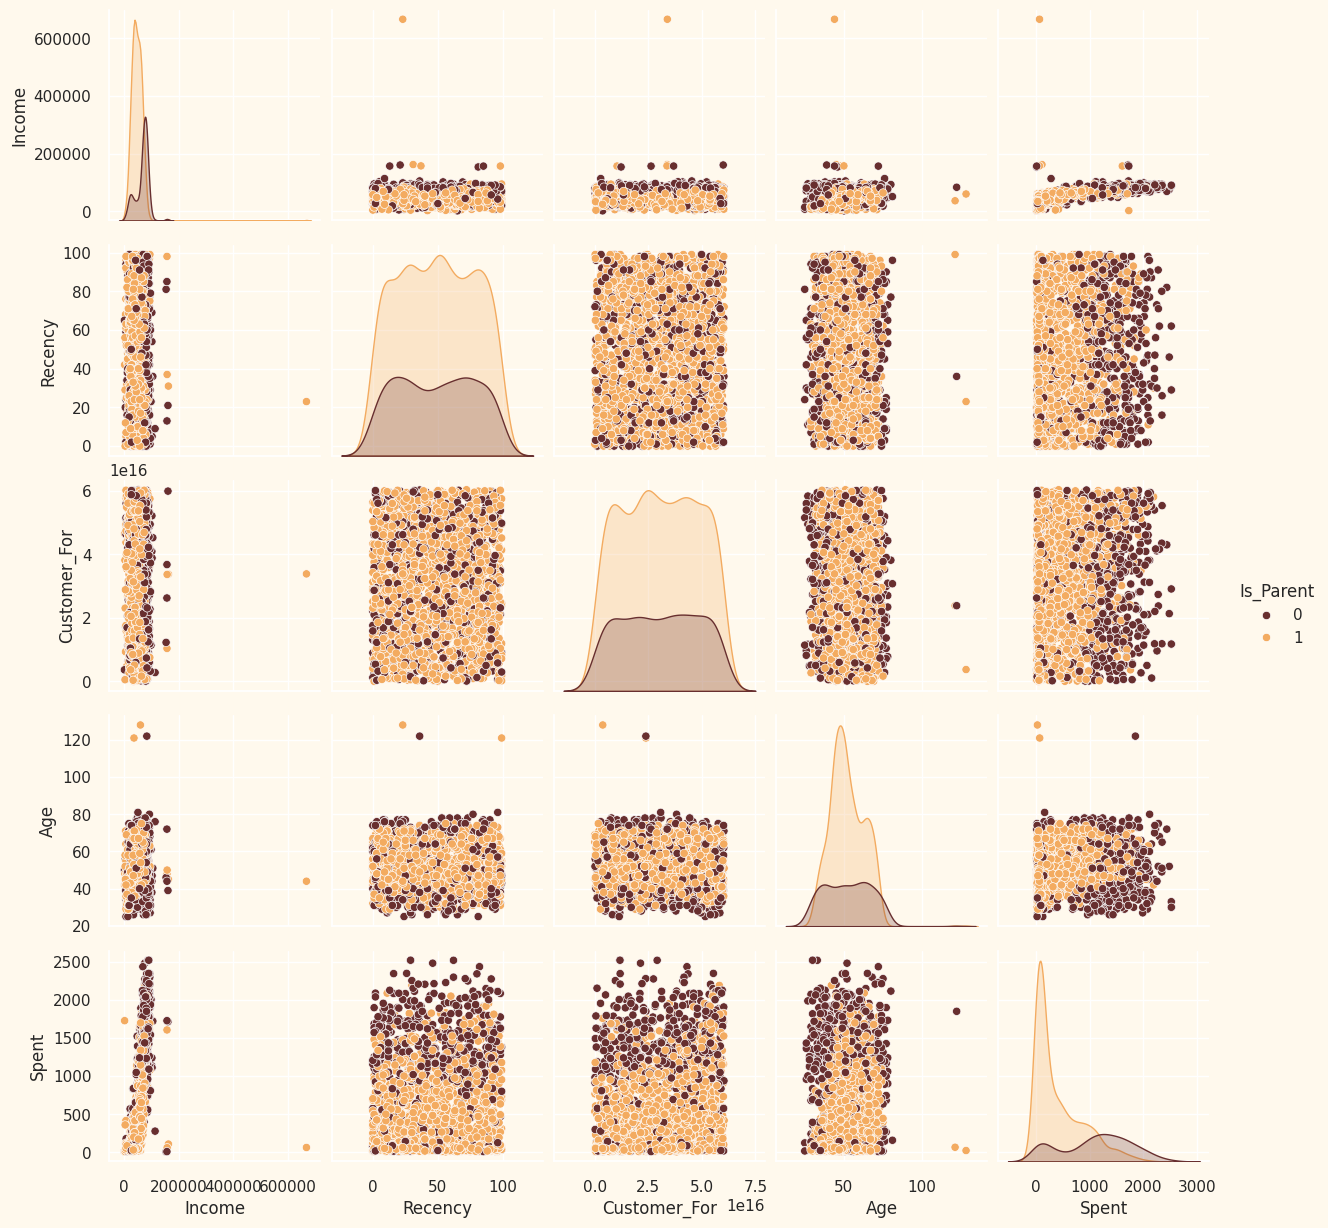

In [13]:
#To plot some selected features
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue
plt.show()

In [14]:
#Dropping the outliers by setting a cap on Age and income.
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


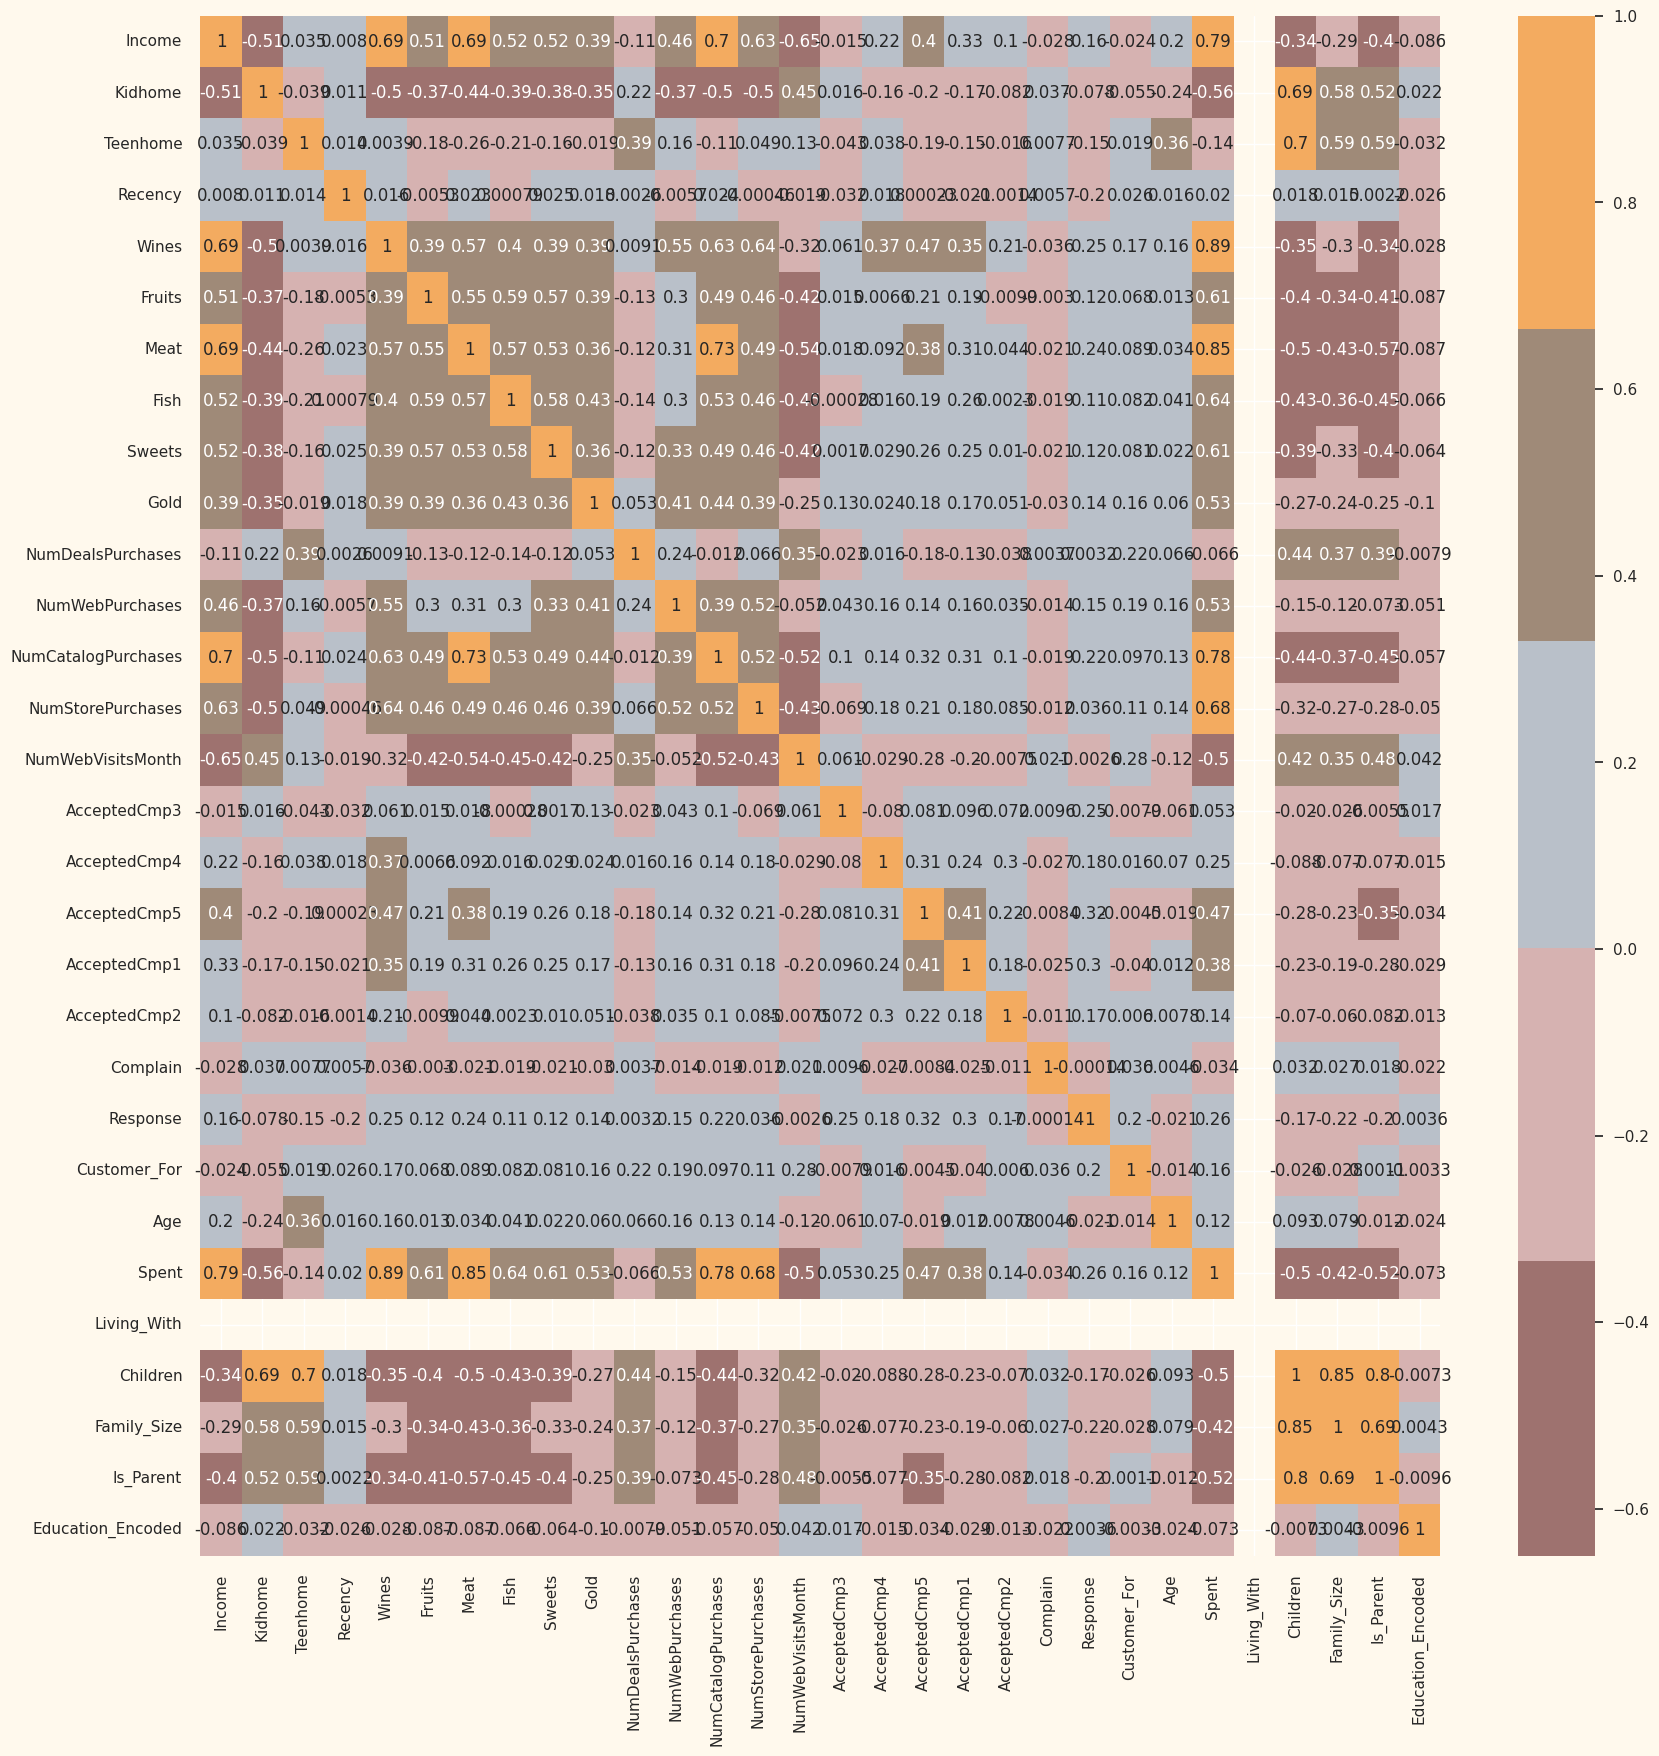

In [15]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit and transform the 'Education' column
data['Education_Encoded'] = label_encoder.fit_transform(data['Education'])

# Now, calculate the correlation matrix, excluding the original 'Education' column

# Convert 'Living_With' column to numeric before calculating correlation
data['Living_With'] = pd.to_numeric(data['Living_With'], errors='coerce') # convert non-numeric to NaN if any

corrmat = data.drop(columns=['Education']).corr() # Now calculate the correlation

# Continue with your plotting code
plt.figure(figsize=(20, 20))
sns.heatmap(corrmat, annot=True, cmap=cmap, center=0)
plt.show()

In [16]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education']


In [17]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)

print("All features are now numerical")



All features are now numerical


In [18]:
#Creating a copy of data
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [19]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent,Education_Encoded
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,-0.555814,0.692181,1.527721,1.018352,1.676245,NaN,-1.264598,-1.758359,-1.581139,-0.893586
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,NaN,1.404572,0.449070,0.632456,-0.893586
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,1.290224,-0.544908,-0.206048,0.334530,0.280110,NaN,-1.264598,-0.654644,-1.581139,-0.893586
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,NaN,0.069987,0.449070,0.632456,-0.893586
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,NaN,0.069987,0.449070,0.632456,0.571657


In [37]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Misal data asli disimpan dalam variabel 'ds'
# Contoh: ds = pd.read_csv('data.csv')
print("Shape dataset awal:", ds.shape)
print("Jumlah NaN per kolom:\n", ds.isna().sum())
print("Jumlah infinite per kolom:\n", np.isinf(ds).sum())

# Jika terdapat kolom dengan seluruh nilai NaN (misalnya 'Living_With'),
# pertimbangkan untuk menghapus kolom tersebut karena tidak memberikan informasi.
if ds['Living_With'].isna().sum() == ds.shape[0]:
    ds = ds.drop(columns=['Living_With'])
    print("Kolom 'Living_With' dihapus karena semua nilainya NaN.")

print("Shape dataset setelah penghapusan kolom dengan NaN semua:", ds.shape)

# Ganti nilai infinite dengan NaN agar dapat ditangani
ds.replace([np.inf, -np.inf], np.nan, inplace=True)

# Hapus baris yang mengandung nilai NaN (jika ada)
ds_clean = ds.dropna()
print("Shape dataset setelah cleaning:", ds_clean.shape)

# Lakukan scaling data menggunakan StandardScaler
scaler = StandardScaler()
scaled_ds = scaler.fit_transform(ds_clean)
print("Shape dataset setelah scaling:", scaled_ds.shape)

# Terapkan PCA untuk mereduksi dimensi menjadi 3 komponen
pca = PCA(n_components=3)
pca_transformed = pca.fit_transform(scaled_ds)

# Buat DataFrame untuk menyimpan hasil transformasi PCA
pca_df = pd.DataFrame(pca_transformed, columns=["PC1", "PC2", "PC3"])

# Tampilkan statistik deskriptif (transposed) dari hasil PCA
print("Deskripsi statistik dari hasil PCA:")
print(pca_df.describe().T)


Shape dataset awal: (2212, 24)
Jumlah NaN per kolom:
 Education                 0
Income                    0
Kidhome                   0
Teenhome                  0
Recency                   0
Wines                     0
Fruits                    0
Meat                      0
Fish                      0
Sweets                    0
Gold                      0
NumDealsPurchases         0
NumWebPurchases           0
NumCatalogPurchases       0
NumStorePurchases         0
NumWebVisitsMonth         0
Customer_For              0
Age                       0
Spent                     0
Living_With            2212
Children                  0
Family_Size               0
Is_Parent                 0
Education_Encoded         0
dtype: int64
Jumlah infinite per kolom:
 Education              0
Income                 0
Kidhome                0
Teenhome               0
Recency                0
Wines                  0
Fruits                 0
Meat                   0
Fish                   0
Sweets  

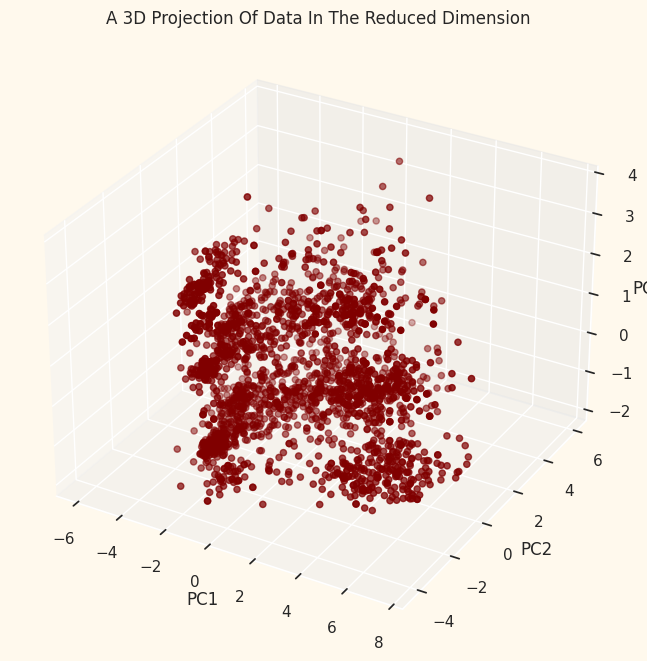

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Hanya diperlukan untuk matplotlib versi lama

# Misal, DataFrame hasil PCA disimpan dalam variabel 'pca_df' dengan kolom "PC1", "PC2", "PC3"
x = pca_df["PC1"]
y = pca_df["PC2"]
z = pca_df["PC3"]

# Membuat figure dan subplot 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Membuat scatter plot
ax.scatter(x, y, z, c="maroon", marker="o")

# Menambahkan judul dan label sumbu
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

# Menampilkan plot
plt.show()

Elbow Method to determine the number of clusters to be formed:


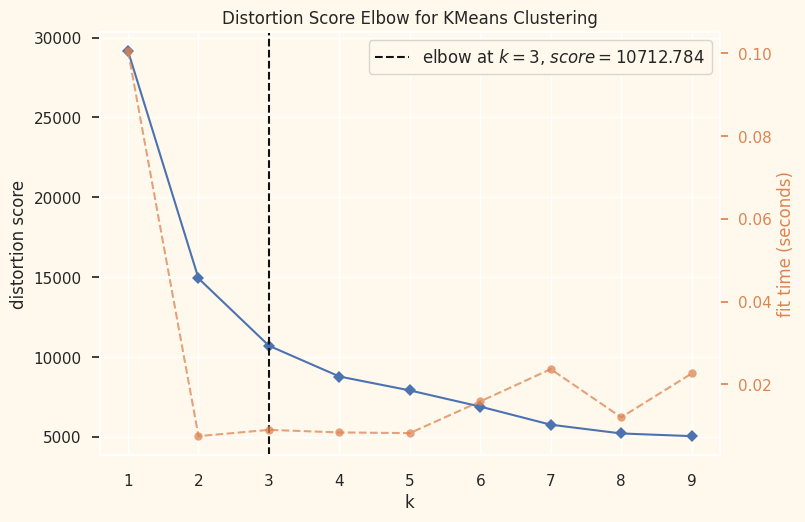

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [41]:
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

print("Elbow Method to determine the number of clusters to be formed:")

# Gunakan DataFrame hasil PCA, misalnya 'pca_df'
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(1, 10))
visualizer.fit(pca_df)
visualizer.show()

In [43]:
from sklearn.cluster import AgglomerativeClustering

# Inisialisasi model Agglomerative Clustering dengan 4 cluster
ac = AgglomerativeClustering(n_clusters=4)

# Fit model dan prediksi cluster menggunakan data hasil PCA
yhat_ac = ac.fit_predict(pca_df)

# Menambahkan kolom 'Clusters' ke DataFrame hasil PCA
pca_df["Clusters"] = yhat_ac

# Menambahkan kolom 'Clusters' ke DataFrame asli
data["Clusters"] = yhat_ac

# Tampilkan distribusi cluster pada data
print("Distribusi cluster pada data PCA:")
print(pca_df["Clusters"].value_counts())
print("\nDistribusi cluster pada data asli:")
print(data["Clusters"].value_counts())

Distribusi cluster pada data PCA:
Clusters
0    731
1    670
2    480
3    331
Name: count, dtype: int64

Distribusi cluster pada data asli:
Clusters
0    731
1    670
2    480
3    331
Name: count, dtype: int64


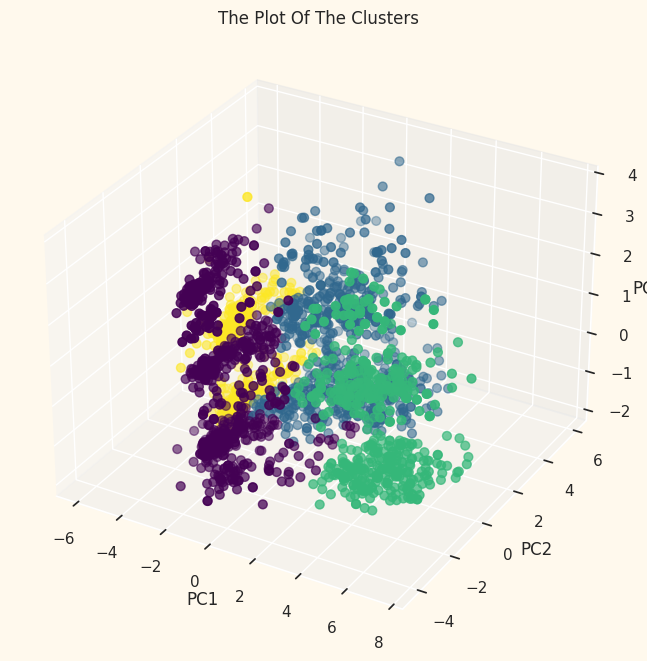

In [45]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Opsional, tergantung versi matplotlib

# Misal, DataFrame hasil PCA adalah 'pca_df' dan memiliki kolom "PC1", "PC2", "PC3", "Clusters"
x = pca_df["PC1"]
y = pca_df["PC2"]
z = pca_df["PC3"]

# Jika belum didefinisikan, tetapkan cmap default (misalnya 'viridis')
cmap = plt.cm.viridis

# Membuat figure dan subplot 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting cluster
scatter = ax.scatter(x, y, z, s=40, c=pca_df["Clusters"], marker='o', cmap=cmap)

# Menambahkan judul dan label sumbu
ax.set_title("The Plot Of The Clusters")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

# Menampilkan plot
plt.show()

<ipython-input-46-2f63248a592e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=data["Clusters"], palette= pal)


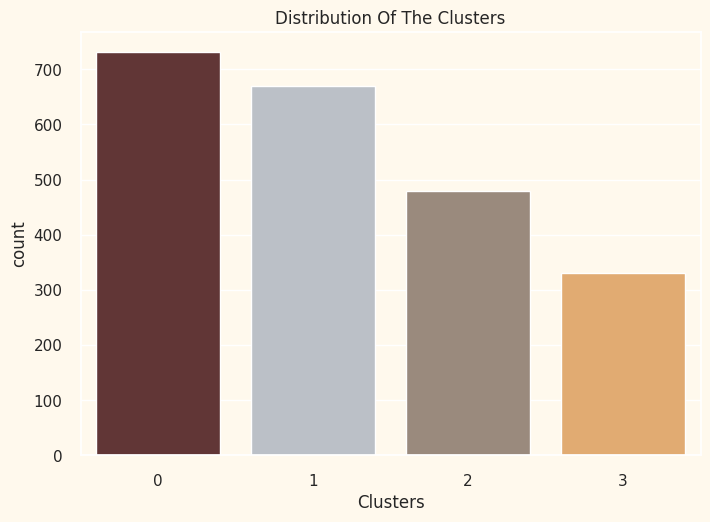

In [46]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

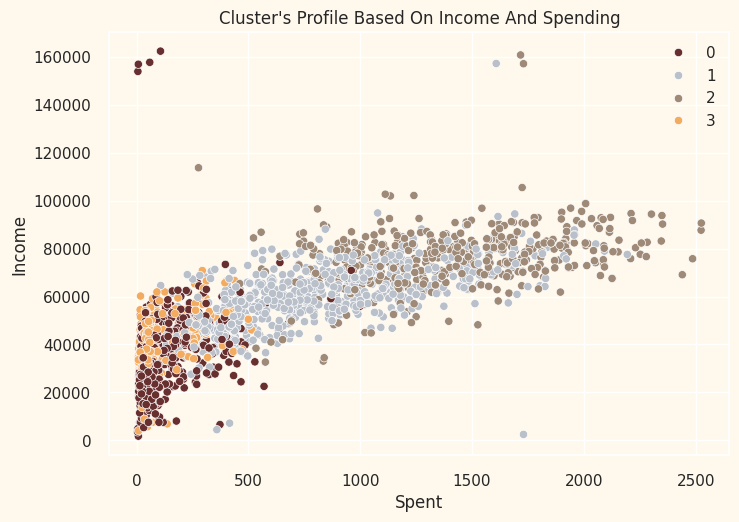

In [47]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()